In [ ]:
"""
This notebook scrapes labels from adfontesmedia.com and scrapes the news articles linked by 
this website to generate a dataset with text from news articles and labels.  We then use this
data to train a logistic regression model to classify fake news and real news
"""

In [132]:
import pandas as pd
import pickle
from bs4 import BeautifulSoup
import requests
import time
import matplotlib.pyplot as plt

In [291]:
# Scrapes the articles and the ratings by adfontesmedia.com and saves them into a list 
source_code = requests.get('https://www.adfontesmedia.com/rankings-by-individual-news-source/')
soup = BeautifulSoup(source_code.text, 'html5lib')
news = []
for source in soup.find_all('div', class_="fusion-post-content post-content")[105:]:
    outlet = source.get_text()
    source_code_2 = requests.get(source.find('a').get('href'))
    soup2 = BeautifulSoup(source_code_2.text, 'html5lib')
    print(outlet)
    if soup2.find('figure', class_="wp-block-table") == None:
        try:
            articles = soup2.find('div', class_="table-1").find('tbody').find_all('tr')
        except:
            articles = soup2.find('tbody').find_all('tr')
    else:
        articles = soup2.find('figure', class_="wp-block-table").find('tbody').find_all('tr')
    for article in articles:
        if article.find('a') != None:
            ratings = article.find_all('td')
            bias = ratings[1].get_text()
            reliability = ratings[2].get_text()
            source_code_3 = requests.get(article.find('a').get('href'))
            soup3 = BeautifulSoup(source_code_3.text, 'html5lib')
            visible = soup3.find_all(text=True)
            text = ''
            for tag in visible:
                if tag.parent.name in ['p', 'a']:
                    text += ' ' + tag
            news.append([outlet, text, bias, reliability])
            time.sleep(1)

The Skimm Bias and Reliability
The Weather Channel Bias and Reliability
The Week Bias and Reliability
ThinkProgress Bias and Reliability
Time Magazine Bias and Reliability
TMZ Bias and Reliability
Townhall – Bias and Reliability
Truthout Bias and Reliability
Twitchy Bias and Reliability
UrNews24 Bias and Reliability
USA Today Bias and Reliability
Vanity Fair Bias and Reliability
Vice Bias and Reliability
Vox Bias and Reliability
Wall Street Journal Bias and Reliability
Washington Examiner Bias and Reliability
Washington Free Beacon Bias and Reliability
Washington Monthly Bias and Reliability
Washington Post Bias and Reliability
Washington Times Bias and Reliability
Wonkette Bias and Reliability
World Truth TV Bias and Reliability
WorldNetDaily Bias and Reliability
ZeroHedge Bias and Reliability


In [293]:
# Takes the scraped data that is in the list and saves it into a dataframe
df = pd.DataFrame(news, columns = ['Source', 'Text', 'Bias', 'Reliability'])

In [61]:
# Length of dataframe
len(df)

2050

In [82]:
with open('adfonte_media.pickle', 'wb') as to_write:
    pickle.dump(df_main, to_write)

In [382]:
# Cleans up the text in the dataframe.  
import re
import string

us = lambda x: re.sub("U.S", 'us', x)
cleanup2 = lambda x: re.sub("\n", '', x)
cleanup3 = lambda x: re.sub("\t", '', x)
apostrophe = lambda x: re.sub("\'", '', x)
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

df['text'] = df['Text'].map(us).map(apostrophe).map(alphanumeric).map(punc_lower).map(cleanup2).map(cleanup3)
df.head()

,Source,Text,Bias,Reliability,text,reliability,true
0,ABC News Bias and Reliability,U.S. cyber operators disrupted internet acces...,[-5.33],[52.33],us cyber operators disrupted internet access...,52.33,1
1,ABC News Bias and Reliability,A federal appeals court rejected the most dir...,[0.67],[51.67],a federal appeals court rejected the most dir...,51.67,1
2,ABC News Bias and Reliability,"U.S Senator Elizabeth Warren , who is compet...",[-10.00],[32.00],us senator elizabeth warren who is competi...,32.00,1
3,ABC News Bias and Reliability,Facebook announced Tuesday that it will bl...,[-2.33],[52.33],facebook announced tuesday that it will bl...,52.33,1
4,ABC News Bias and Reliability,"President Donald Trump and ""the Trump of th...",[-4.33],[52.67],president donald trump and the trump of th...,52.67,1


In [74]:
# Sets recursion limit so doesn't through a recursion exception
import sys
sys.setrecursionlimit(100000)

In [307]:
# Methods to fix the reliability and source columns of the dataframe
fix_source = lambda x: re.sub('Bias and Reliability', x)
fix_text = lambda x: ''.join(re.findall('[0-9.-]', x))

In [11]:
# Generates a column, 'bias', which gets the bias as a float
df['bias']= df['Bias']
df['bias'] = ''.join(re.findall('[0-9.]', df['Bias']))

TypeError: expected string or bytes-like object

In [425]:
# Selects the text and true column of dataframe and makes new dataframe
df_main = df[['text', 'true']]

In [44]:
def get_num(row, variable):
    """
    Takes in a dataframe row and finds numerical value that is within a line  
    of text.  Returns that value as a float
    """
    string = str(row[variable])
    if len(string) <10:
        string = re.sub(',', '.', string)
        return float(string)
    else:
        return float(''.join(re.findall('[0-9.]', string[-15:])))

In [419]:
def label_news(row):
    """
    Takes in a row and converts reliability into a 1,0 binary rating system, 
    where 1 is real news and 0 is fake news
    """
    reliability = row['reliability']
    if reliability < 30:
        return 0
    else:
        return 1

In [54]:
# Gets reliability as a float
df['reliability'] = df.apply(get_num, variable = 'Reliability', axis = 1)

In [420]:
# Generates a new column true that is labeled based on reliability
df['true'] = df.apply(label_news, axis = 1)

In [421]:
df.head()

,Source,Text,Bias,Reliability,text,reliability,true
0,ABC News Bias and Reliability,U.S. cyber operators disrupted internet acces...,[-5.33],[52.33],us cyber operators disrupted internet access...,52.33,1
1,ABC News Bias and Reliability,A federal appeals court rejected the most dir...,[0.67],[51.67],a federal appeals court rejected the most dir...,51.67,1
2,ABC News Bias and Reliability,"U.S Senator Elizabeth Warren , who is compet...",[-10.00],[32.00],us senator elizabeth warren who is competi...,32.00,1
3,ABC News Bias and Reliability,Facebook announced Tuesday that it will bl...,[-2.33],[52.33],facebook announced tuesday that it will bl...,52.33,1
4,ABC News Bias and Reliability,"President Donald Trump and ""the Trump of th...",[-4.33],[52.67],president donald trump and the trump of th...,52.67,1


In [394]:
# Gets politifact pickle.  Turns out there is far more real articles than fake articles
# and I wanted to increase the number of fake articles, thus using the politifact dataset
file_path = 'politifact.pickle'
polifact = pd.read_pickle(file_path)

In [429]:
# Generates a combined dataframe with politifact and adfontesmedia data
df_comb = pd.concat([df_main, polifact])

In [434]:
# Split the data into X and y data sets
X = df_comb['text']
y = df_comb['true']

In [435]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [436]:
# Generates an tf-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

In [488]:
# Save the tf-idf vectorizer as a pickle
pickle.dump(tfidf1, open('tfidf1.pickle', 'wb'))

In [412]:
# Generates an tf-idf vectorizer with bigrams  Tried this with the logistic regression
# model and got worse results, so stuck with the unigram vectorizer
tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

In [437]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [485]:
# This method takes actual values and predicted values and produces a confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    fig, ax = plt.subplots(1, 1, figsize=(10,5), dpi = 200);
    g = sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    ax.set_yticklabels(['actual_negative', 'actual_positive'],color = 'white')
    ax.set_xticklabels(['predicted_negative', 'predicted_positive'],color = 'white')

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    plt.savefig('conf_matrix', transparent=True);
    return cm_results

In [415]:
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from imblearn.over_sampling import RandomOverSampler

In [447]:
# Balance the classes by oversampling
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train_tfidf1,y_train)

In [486]:
# Fit the first logistic regression on the TF-IDF data with unigrams
# Tried with bigrams too but got worse results
lr.fit(X_resampled, y_resampled)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)


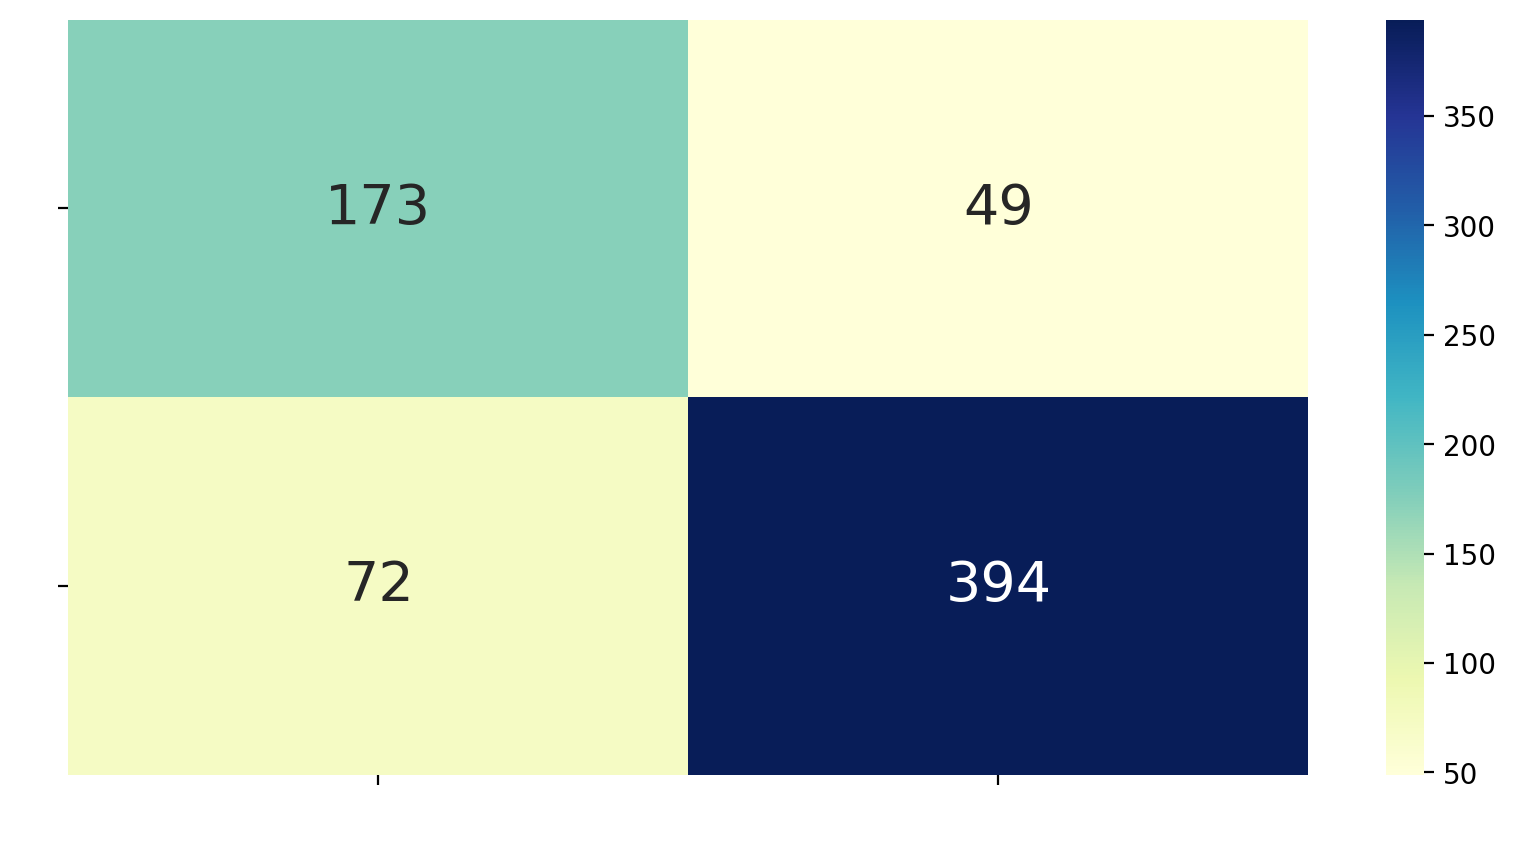

In [484]:
# Prints the confusion matrix for this model
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

In [449]:
# Gives the classification report for the logistic regression model
print(classification_report(y_test, y_pred_tfidf1_lr ))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       222
           1       0.89      0.85      0.87       466

    accuracy                           0.82       688
   macro avg       0.80      0.81      0.80       688
weighted avg       0.83      0.82      0.83       688



In [487]:
# Save the logistic regression as a pickle file
pickle.dump(lr, open('log_reg', 'wb'))

In [440]:
# Save the combined dataframe as a pickle file
with open('df_comb.pickle', 'wb') as to_write:
    pickle.dump(df_comb, to_write)